[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data Head:
                  PL=F         PA=F
Date                               
2023-07-03  909.299988  1218.400024
2023-07-05  918.099976  1249.300049
2023-07-06  904.500000  1230.800049
2023-07-07  910.099976  1236.500000
2023-07-10  929.200012  1228.099976
P-value: 0.03650789881247105
Spread:
Date
2023-07-03   -137.523833
2023-07-05   -155.272500
2023-07-06   -152.977663
2023-07-07   -152.274966
2023-07-10   -125.957804
dtype: float64
Z-score:
Date
2023-07-03   -1.257603
2023-07-05   -1.406070
2023-07-06   -1.386874
2023-07-07   -1.380996
2023-07-10   -1.160853
dtype: float64
Signals Head:
            longs  shorts  exits
Date                            
2023-07-03   True   False  False
2023-07-05   True   False  False
2023-07-06   True   False  False
2023-07-07   True   False  False
2023-07-10   True   False  False
Positions:
                PL=F      PA=F
Date                          
2023-07-03  1.099747 -0.820749
2023-07-05  1.089206 -0.800448
2023-07-06  1.105583 -0.812480


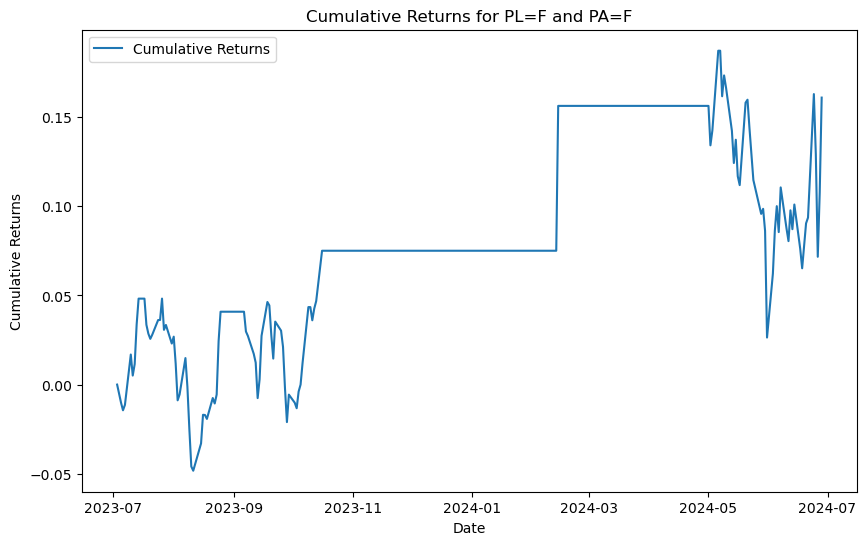

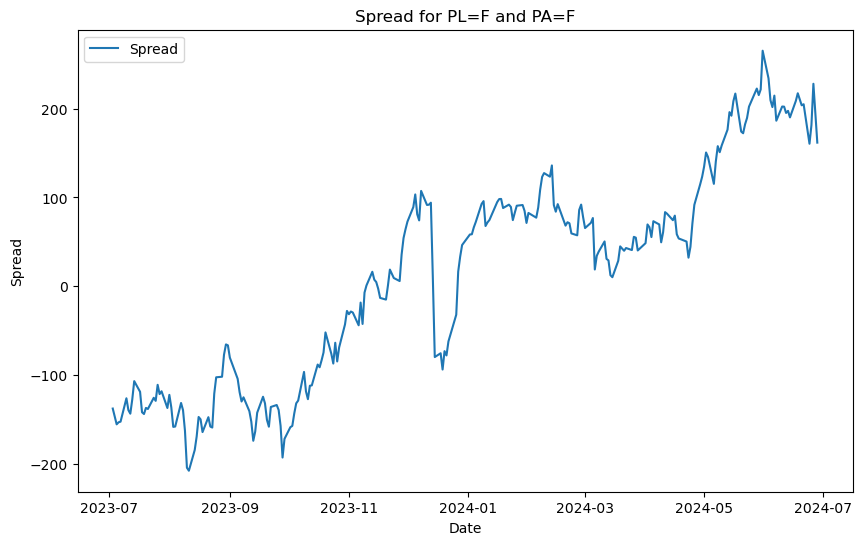

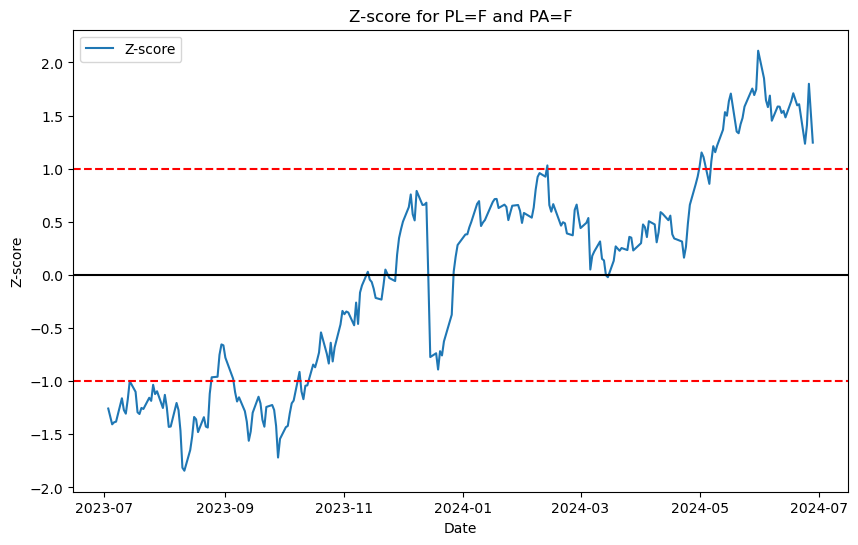

In [7]:
### Library Imports
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Function to Get Commodities Data
def import_commod_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for t in tickers:
        data[t] = yf.download(t, start=start_date, end=end_date)['Adj Close']
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    return data

### Function to Compute Spread and Z-Score
def spread_and_zscore(series1, series2):
    # Calculate the hedge ratio using OLS
    hedge_ratio = sm.OLS(series1, series2).fit().params[0]
    spread = series1 - hedge_ratio * series2
    z_score = (spread - spread.mean()) / spread.std()
    return spread, z_score

### Function to Check for Cointegration
def check_cointegration(series1, series2):
    result = sm.tsa.stattools.coint(series1, series2)
    p_val = result[1]
    return p_val

### Function to Generate Trading Signals
def generate_signals(spread, z_score):
    longs = z_score < -1
    shorts = z_score > 1
    exits = (z_score > -0.5) & (z_score < 0.5)
    
    signals = pd.DataFrame(index=spread.index)
    signals['longs'] = longs
    signals['shorts'] = shorts
    signals['exits'] = exits
    
    return signals

### Function to Calculate the Position
def backtest(signals, data, commodities):
    positions = pd.DataFrame(index=signals.index)
    positions[commodities[0]] = 0
    positions[commodities[1]] = 0
    portfolio_value = 2000  # Total investment of $2000 (1000 long and 1000 short)

    for i in range(len(signals)):
        if signals['longs'].iloc[i]:
            positions.iloc[i] = [1000 / data[commodities[0]].iloc[i], -1000 / data[commodities[1]].iloc[i]]
        elif signals['shorts'].iloc[i]:
            positions.iloc[i] = [-1000 / data[commodities[0]].iloc[i], 1000 / data[commodities[1]].iloc[i]]
        elif signals['exits'].iloc[i]:
            positions.iloc[i] = [0, 0]

    daily_rets = data.pct_change().dropna()
    returns = (positions.shift(1) * daily_rets).sum(axis=1)
    cumulative_rets = (returns + 1).cumprod() - 1
    portfolio_values = (cumulative_rets + 1) * portfolio_value

    return positions, returns, cumulative_rets, portfolio_values

### Function to Compute Performance Metrics
def calculate_performance_metrics(portfolio_values, returns):
    total_return = portfolio_values.iloc[-1] - 2000  # Final portfolio value minus initial investment
    percentage_return = (total_return / 2000) * 100
    annualized_return = ((1 + percentage_return / 100) ** (252 / len(portfolio_values)) - 1) * 100
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    
    return total_return, percentage_return, annualized_return, sharpe_ratio

### Function to Plot Results
def plots(spread, cumulative_rets, z_score, pair):
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rets, label='Cumulative Returns')
    plt.title(f'Cumulative Returns for {pair[0]} and {pair[1]}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(spread, label='Spread')
    plt.title(f'Spread for {pair[0]} and {pair[1]}')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(z_score, label='Z-score')
    plt.title(f'Z-score for {pair[0]} and {pair[1]}')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    plt.axhline(1.0, color='r', linestyle='--')
    plt.axhline(-1.0, color='r', linestyle='--')
    plt.axhline(0.0, color='k', linestyle='-')
    plt.legend()
    plt.show()

### Main Execution
commodities_list = ['PL=F', 'PA=F']
start_date = '2023-07-01'
end_date = '2024-07-01'

# Import data
data = import_commod_data(commodities_list, start_date, end_date)
print("Data Head:")
print(data.head())

# Check for cointegration
p_value = check_cointegration(data[commodities_list[0]], data[commodities_list[1]])
print(f"P-value: {p_value}")

# Compute Spread and Z-Score
spread, z_score = spread_and_zscore(data[commodities_list[0]], data[commodities_list[1]])
print("Spread:")
print(spread.head())
print("Z-score:")
print(z_score.head())

# Generate Signals
signals = generate_signals(spread, z_score)
print("Signals Head:")
print(signals.head())

# Backtest the strategy
positions, returns, cumulative_rets, portfolio_values = backtest(signals, data, commodities_list)
print("Positions:")
print(positions.head())
print("Returns:")
print(returns.head())
print("Cumulative Returns:")
print(cumulative_rets.head())
print("Portfolio Values:")
print(portfolio_values.head())

# Calculate Performance Metrics
total_return, percentage_return, annualized_return, sharpe_ratio = calculate_performance_metrics(portfolio_values, returns)
print(f"Total Return: ${total_return:.2f}")
print(f"Percentage Return: {percentage_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot the results
plots(spread, cumulative_rets, z_score, commodities_list)
